## Exogenous Variables with PyAF

PyAF allows using some external sources to improve its forecasts. 

In addition to the training dataset, the user can provide an external table with exogenous variables data. This table is merged with the signal dataset when exogenous vairables values are need (either when training the model or when  producing forecasts).

The signal and exogenous variables can come from the same table (self-join).




### Exogenous variables Modeling

All PyAF models are of the form of a linear decomposition (Trend + Periodic + AR). The exogenous avriables are introduced in the AR component through thier past values.


Before working with exogenous variables, they need to be first transformed into a numerical form (encoed). PyAF used standrd encoding procedures. Non-numerical exogenous variables are dummified (a binary column is created for each distinct column value) and numericcal columns are stadanrdiozed ( Y = (X-m)/s , where m is the mean and s is the standard deviation) 

### Example with Ozone dataset

For demosntration puroposes, we tranform the Loas Angeles ozone dataset so that it contains some exogenous variables. In a real case, these variables can provide some information on Los Angeles (population , temperature, ...) on the same period.

Here, 4 variables have been created artificially.

In [1]:
import numpy as np
import pandas as pd
import datetime

csvfile_link = "https://raw.githubusercontent.com/antoinecarme/pyaf/master/data/ozone-la-exogenous-2.csv"
exog_dataframe = pd.read_csv(csvfile_link);
exog_dataframe['Date'] = exog_dataframe['Date'].astype(np.datetime64);

print(exog_dataframe.info())
exog_dataframe.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216 entries, 0 to 215
Data columns (total 5 columns):
Date     216 non-null datetime64[ns]
Exog2    216 non-null int64
Exog3    216 non-null int64
Exog4    216 non-null object
Exog5    216 non-null object
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 8.5+ KB
None


,Date,Exog2,Exog3,Exog4,Exog5
0,1955-01-01,2,3,F,M
1,1955-02-01,3,5,G,L
2,1955-03-01,5,6,G,L
3,1955-04-01,6,6,F,M
4,1955-05-01,6,5,F,N


This table contains for each 'Date' value, two numeriocal exogenous variable ('Exog2' and 'Exog3') and two character(object) variables ('Exog4' and 'Exog5')

This is how the encoded dataset looks like internally:
    

In [2]:
encoded_csvfile_link = "https://raw.githubusercontent.com/antoinecarme/pyaf/master/data/ozone_exogenous_encoded.csv"
encoded_ozone_dataframe = pd.read_csv(encoded_csvfile_link);
# print(encoded_ozone_dataframe.columns)
interesting_Columns = ['Date',
                       'Ozone', 'Exog2', 
                       'Exog2',
                       'Exog3', 
                       'Exog4=E', 'Exog4=F', 'Exog4=C', 'Exog4=D', 'Exog4=B',
                       'Exog5=K', 'Exog5=L', 'Exog5=M', 'Exog5=N'];

encoded_ozone_dataframe = encoded_ozone_dataframe[interesting_Columns]
print(encoded_ozone_dataframe.info())
encoded_ozone_dataframe.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216 entries, 0 to 215
Data columns (total 14 columns):
Date       216 non-null object
Ozone      216 non-null float64
Exog2      216 non-null float64
Exog2      216 non-null float64
Exog3      216 non-null float64
Exog4=E    216 non-null int64
Exog4=F    216 non-null int64
Exog4=C    216 non-null int64
Exog4=D    216 non-null int64
Exog4=B    216 non-null int64
Exog5=K    216 non-null int64
Exog5=L    216 non-null int64
Exog5=M    216 non-null int64
Exog5=N    216 non-null int64
dtypes: float64(4), int64(9), object(1)
memory usage: 23.7+ KB
None


,Date,Ozone,Exog2,Exog2,Exog3,Exog4=E,Exog4=F,Exog4=C,Exog4=D,Exog4=B,Exog5=K,Exog5=L,Exog5=M,Exog5=N
0,1955-01-01,2.7,-1.034795,-1.034795,-0.400168,0,1,0,0,0,0,0,1,0
1,1955-02-01,2.0,-0.391010,-0.391010,0.891463,0,0,0,0,0,0,1,0,0
2,1955-03-01,3.6,0.896559,0.896559,1.537278,0,0,0,0,0,0,1,0,0
3,1955-04-01,5.0,1.540344,1.540344,1.537278,0,1,0,0,0,0,0,1,0
4,1955-05-01,6.5,1.540344,1.540344,0.891463,0,1,0,0,0,0,0,0,1


### Training process

The only addition in this case, is an extra parameter for the train function that gives the name of the exogenous table and the list of exogenous variables to be used


In [3]:
import pyaf.ForecastEngine as autof
lEngine = autof.cForecastEngine()

csvfile_link = "https://raw.githubusercontent.com/antoinecarme/TimeSeriesData/master/ozone-la.csv"
ozone_dataframe = pd.read_csv(csvfile_link);
ozone_dataframe['Date'] = ozone_dataframe['Month'].apply(lambda x : datetime.datetime.strptime(x, "%Y-%m"))

print(ozone_dataframe.info())

lExogenousData = (exog_dataframe , ['Exog2' , 'Exog3' , 'Exog4',  'Exog5']) 

lEngine.train(ozone_dataframe , 'Date' , 'Ozone', 12 , lExogenousData);


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216 entries, 0 to 215
Data columns (total 3 columns):
Month    216 non-null object
Ozone    216 non-null float64
Date     216 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 5.1+ KB
None


In [4]:
lEngine.getModelInfo()

In this specific model, the ARX cxomponent shows that the most important predictors are (in this order):
1. The previous value of Exog2 (Exog2_Lag1)
2. The value of Exog3 two months ago (Exog3_Lag2)
3. The fact that the previous value of Exog4 is 'F' or not (Exog4=F_Lag1).
4. The value of Exog2 two months ago (Exog2_Lag2)
5. etc ...

### The effect of introducing the exogenous variables.


In [5]:
lEngine_Without_Exogenous = autof.cForecastEngine()

lEngine_Without_Exogenous.train(ozone_dataframe , 'Date' , 'Ozone', 12);


In [6]:
lEngine_Without_Exogenous.getModelInfo()

In [7]:
ozone_forecast_without_exog = lEngine_Without_Exogenous.forecast(ozone_dataframe, 12);
ozone_forecast_with_exog = lEngine.forecast(ozone_dataframe, 12);



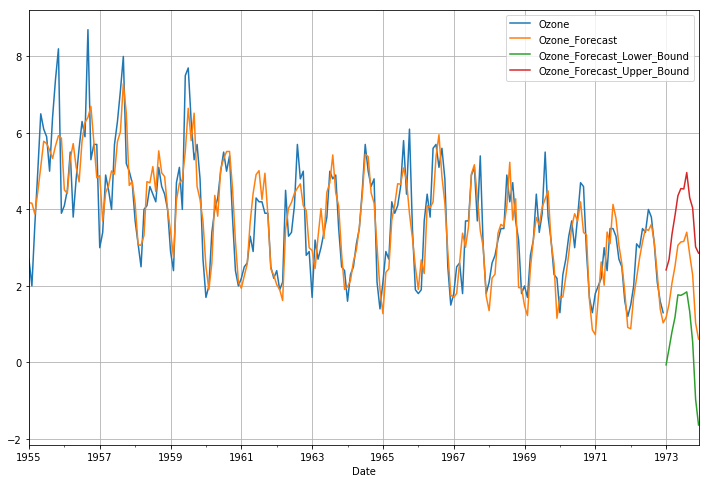

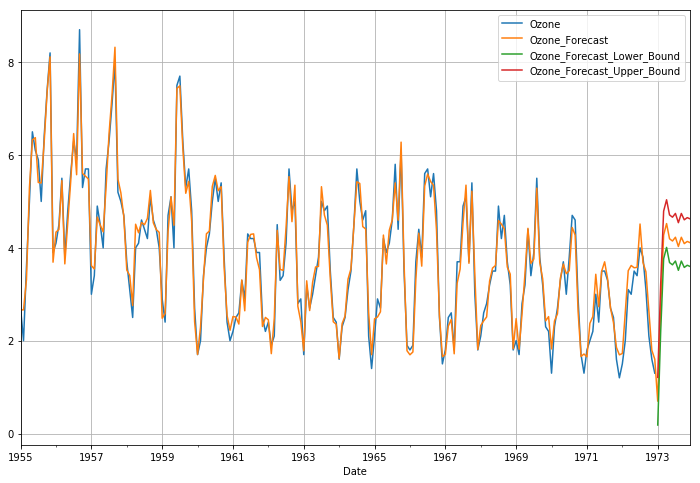

In [8]:
%matplotlib inline  
ozone_forecast_without_exog.plot.line('Date', ['Ozone' , 'Ozone_Forecast', 
                                             'Ozone_Forecast_Lower_Bound', 
                                             'Ozone_Forecast_Upper_Bound'], grid = True, figsize=(12, 8))
ozone_forecast_with_exog.plot.line('Date', ['Ozone' , 'Ozone_Forecast', 
                                             'Ozone_Forecast_Lower_Bound', 
                                             'Ozone_Forecast_Upper_Bound'], grid = True, figsize=(12, 8))